In [20]:
!pip -q install numpy scipy pandas matplotlib psutil

import os, tarfile, gzip, shutil, time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import psutil
from scipy.io import mmread
from scipy import sparse
from scipy.sparse.linalg import svds

def rss_mb():
    return psutil.Process(os.getpid()).memory_info().rss / (1024**2)


In [21]:
def make_synthetic_matrix(m, n, r, kind="lowrank_noise", noise=0.01, alpha=0.08, seed=0):
    rng = np.random.default_rng(seed)
    U0, _ = np.linalg.qr(rng.standard_normal((m, r)))
    V0, _ = np.linalg.qr(rng.standard_normal((n, r)))

    if kind == "lowrank_noise":
        s = np.linspace(50, 1, r)
    elif kind == "slow":  # sigma_i ~ 1/i
        s = 1.0 / np.arange(1, r + 1)
        s = 50 * s / s[0]
    elif kind == "fast":  # sigma_i ~ exp(-alpha i)
        s = np.exp(-alpha * np.arange(r))
        s = 50 * s / s[0]
    else:
        raise ValueError("Unknown kind")

    A = U0 @ np.diag(s) @ V0.T
    if kind == "lowrank_noise":
        A = A + noise * rng.standard_normal((m, n))
    return A


In [22]:
def load_suitesparse(group, name, cache_dir="suitesparse_cache"):
    cache_dir = Path(cache_dir); cache_dir.mkdir(parents=True, exist_ok=True)
    tgz = cache_dir / f"{group}__{name}.tar.gz"
    out = cache_dir / f"{group}__{name}"; out.mkdir(parents=True, exist_ok=True)

    if not tgz.exists():
        url = f"http://sparse-files.engr.tamu.edu/MM/{group}/{name}.tar.gz"
        print(f"Downloading: {url}")
        !wget -q -O "{tgz}" "{url}"

    if not (out/".extracted").exists():
        with tarfile.open(tgz, "r:gz") as tf:
            tf.extractall(out)
        (out/".extracted").write_text("ok")

    mtx = list(out.rglob("*.mtx"))
    mtx_gz = list(out.rglob("*.mtx.gz"))

    exact = [p for p in mtx if p.name == f"{name}.mtx"]
    exact_gz = [p for p in mtx_gz if p.name == f"{name}.mtx.gz"]

    if exact:
        path = exact[0]
    elif exact_gz:
        gz_path = exact_gz[0]
        path = gz_path.with_suffix("")
        if not path.exists():
            with gzip.open(gz_path, "rb") as f_in, open(path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
    else:
        cand = mtx + mtx_gz
        if not cand:
            raise FileNotFoundError(f"No .mtx/.mtx.gz found in {group}/{name}")
        biggest = max(cand, key=lambda p: p.stat().st_size)
        if biggest.suffix == ".gz":
            path = biggest.with_suffix("")
            if not path.exists():
                with gzip.open(biggest, "rb") as f_in, open(path, "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)
        else:
            path = biggest

    A = mmread(str(path))
    if sparse.issparse(A):
        A = A.tocsr()
    else:
        A = np.array(A)
    return A


In [23]:
def classical_rankk(A, k):
    # For dense: full SVD (OK for synthetic sizes)
    if not sparse.issparse(A):
        U, s, Vt = np.linalg.svd(A, full_matrices=False)
        return (U[:, :k] * s[:k]) @ Vt[:k, :]

    # For sparse: truncated SVD (ARPACK)
    A = A.tocsr()
    U, s, Vt = svds(A, k=k, which="LM")
    idx = np.argsort(s)[::-1]
    U, s, Vt = U[:, idx], s[idx], Vt[idx, :]
    return (U * s) @ Vt

def randomized_rankk(A, k, p=10, q=1, seed=0):
    rng = np.random.default_rng(seed)

    if sparse.issparse(A):
        Aop = A.tocsr()
    else:
        Aop = A

    m, n = Aop.shape
    l = k + p

    Omega = rng.standard_normal((n, l))
    Y = Aop @ Omega

    for _ in range(q):
        Y = Aop @ (Aop.T @ Y)

    Q, _ = np.linalg.qr(Y, mode="reduced")
    B = (Aop.T @ Q).T  # l x n

    Ub, s, Vt = np.linalg.svd(B, full_matrices=False)
    U = Q @ Ub
    return (U[:, :k] * s[:k]) @ Vt[:k, :]


In [24]:
def rel_fro_error(A, Ak):
    if sparse.issparse(A):
        A = A.tocsr()
        ii, jj = A.nonzero()
        Ak_on_nnz = Ak[ii, jj]
        inner = np.dot(A.data, Ak_on_nnz)
        normA2 = np.dot(A.data, A.data)
        normAk2 = float(np.sum(Ak * Ak))
        err2 = normA2 + normAk2 - 2.0 * inner
        err2 = max(err2, 0.0)
        return float(np.sqrt(err2) / np.sqrt(normA2))
    else:
        return float(np.linalg.norm(A - Ak, 'fro') / np.linalg.norm(A, 'fro'))

def time_median(fn, repeats=5, warmup=1):
    for _ in range(warmup):
        fn()
    ts = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        fn()
        ts.append(time.perf_counter() - t0)
    return float(np.median(ts))


In [25]:
def benchmark(A, name, ks, p=10, qs=(0,1,2), repeats=5):
    m, n = A.shape
    ks = [k for k in ks if 1 <= k < min(m, n)]
    rows = []

    print(f"\n=== {name}  shape={A.shape}  {'nnz='+str(A.nnz) if sparse.issparse(A) else 'dense'} ===")

    for k in ks:
        # ---- classical
        holder = {"Ak": None}
        def run_c():
            holder["Ak"] = classical_rankk(A, k)

        mem_before = rss_mb()
        t = time_median(run_c, repeats=repeats, warmup=1)
        mem_after = rss_mb()

        Ak = holder["Ak"]
        err = rel_fro_error(A, Ak)

        rows.append({
            "matrix": name,
            "method": "classical",
            "k": k,
            "p": np.nan,
            "q": np.nan,
            "time_s": t,
            "rel_fro_err": err,
            "mem_mb": mem_after - mem_before,
            "repeats": repeats
        })
        print(f"classical k={k}: t={t:.4f}s err={err:.4f} memΔ={mem_after-mem_before:.1f}MB")

        # ---- randomized
        for q in qs:
            holder = {"Ak": None}
            def run_r():
                holder["Ak"] = randomized_rankk(A, k, p=p, q=q, seed=0)

            mem_before = rss_mb()
            t = time_median(run_r, repeats=repeats, warmup=1)
            mem_after = rss_mb()

            Ak = holder["Ak"]
            err = rel_fro_error(A, Ak)

            rows.append({
                "matrix": name,
                "method": "rsvd",
                "k": k,
                "p": p,
                "q": q,
                "time_s": t,
                "rel_fro_err": err,
                "mem_mb": mem_after - mem_before,
                "repeats": repeats
            })
            print(f"rsvd k={k} p={p} q={q}: t={t:.4f}s err={err:.4f} memΔ={mem_after-mem_before:.1f}MB")

    return pd.DataFrame(rows)


In [26]:
results = []

# --- Synthetic matrices (3 types)
m, n = 400, 300
A1 = make_synthetic_matrix(m, n, r=20, kind="lowrank_noise", noise=0.01, seed=1)
A2 = make_synthetic_matrix(m, n, r=200, kind="slow", seed=2)
A3 = make_synthetic_matrix(m, n, r=200, kind="fast", alpha=0.08, seed=3)

results.append(benchmark(A1, "synthetic_lowrank_noise", ks=[5,10,20], p=10, qs=(0,1,2), repeats=5))
results.append(benchmark(A2, "synthetic_slow_decay", ks=[5,10,20,40,80], p=10, qs=(0,1,2), repeats=5))
results.append(benchmark(A3, "synthetic_fast_decay", ks=[5,10,20,40,80], p=10, qs=(0,1,2), repeats=5))

# --- SuiteSparse matrices
SS = [
    ("Luong", "photogrammetry"),
    ("Luong", "photogrammetry2"),
    # можно добавить третью:
    # ("Newman", "celegansneural"),
]

for g, name in SS:
    A = load_suitesparse(g, name)
    results.append(benchmark(A, f"suitesparse_{g}_{name}", ks=[5,10,20,50,100], p=10, qs=(0,1,2), repeats=5))

res = pd.concat(results, ignore_index=True)
res.to_csv("all_results_svd_rsvd.csv", index=False)
print("\nSaved -> all_results_svd_rsvd.csv")
res.head(10)



=== synthetic_lowrank_noise  shape=(400, 300)  dense ===
classical k=5: t=0.1582s err=0.6478 memΔ=0.2MB
rsvd k=5 p=10 q=0: t=0.0087s err=0.6584 memΔ=0.0MB
rsvd k=5 p=10 q=1: t=0.0266s err=0.6478 memΔ=0.0MB
rsvd k=5 p=10 q=2: t=0.0671s err=0.6478 memΔ=0.0MB
classical k=10: t=0.1101s err=0.3511 memΔ=0.0MB
rsvd k=10 p=10 q=0: t=0.0118s err=0.3544 memΔ=0.0MB
rsvd k=10 p=10 q=1: t=0.0081s err=0.3511 memΔ=0.0MB
rsvd k=10 p=10 q=2: t=0.0135s err=0.3511 memΔ=0.0MB
classical k=20: t=0.1415s err=0.0247 memΔ=0.0MB
rsvd k=20 p=10 q=0: t=0.0134s err=0.0436 memΔ=0.0MB
rsvd k=20 p=10 q=1: t=0.0088s err=0.0247 memΔ=0.0MB
rsvd k=20 p=10 q=2: t=0.0239s err=0.0247 memΔ=0.0MB

=== synthetic_slow_decay  shape=(400, 300)  dense ===
classical k=5: t=0.0893s err=0.3279 memΔ=0.0MB
rsvd k=5 p=10 q=0: t=0.0041s err=0.3719 memΔ=0.0MB
rsvd k=5 p=10 q=1: t=0.0075s err=0.3279 memΔ=0.0MB
rsvd k=5 p=10 q=2: t=0.0110s err=0.3279 memΔ=0.0MB
classical k=10: t=0.1238s err=0.2345 memΔ=0.0MB
rsvd k=10 p=10 q=0: t=0.0108s e

,matrix,method,k,p,q,time_s,rel_fro_err,mem_mb,repeats
0,synthetic_lowrank_noise,classical,5,NaN,NaN,0.158183,0.647782,0.250000,5
1,synthetic_lowrank_noise,rsvd,5,10.0,0.0,0.008738,0.658367,0.000000,5
2,synthetic_lowrank_noise,rsvd,5,10.0,1.0,0.026561,0.647825,0.000000,5
3,synthetic_lowrank_noise,rsvd,5,10.0,2.0,0.067074,0.647782,0.000000,5
4,synthetic_lowrank_noise,classical,10,NaN,NaN,0.110094,0.351088,0.000000,5
5,synthetic_lowrank_noise,rsvd,10,10.0,0.0,0.011768,0.354393,0.000000,5
6,synthetic_lowrank_noise,rsvd,10,10.0,1.0,0.008140,0.351088,0.000000,5
7,synthetic_lowrank_noise,rsvd,10,10.0,2.0,0.013539,0.351088,0.000000,5
8,synthetic_lowrank_noise,classical,20,NaN,NaN,0.141531,0.024663,0.003906,5
9,synthetic_lowrank_noise,rsvd,20,10.0,0.0,0.013427,0.043591,0.000000,5


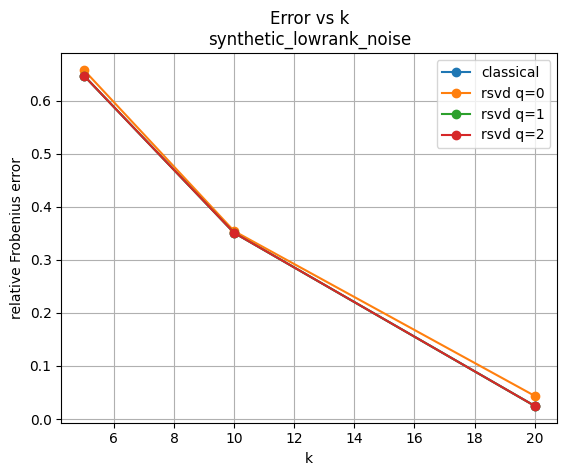

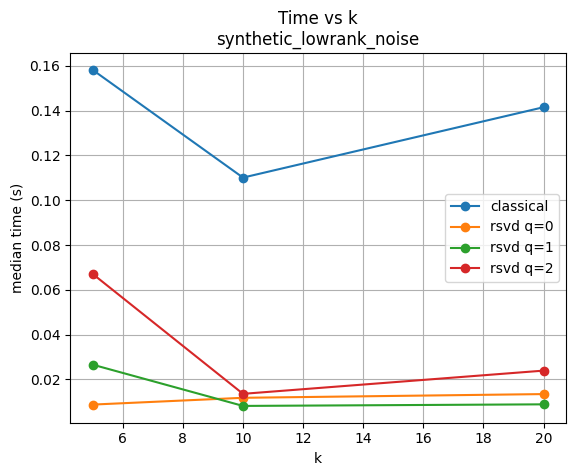

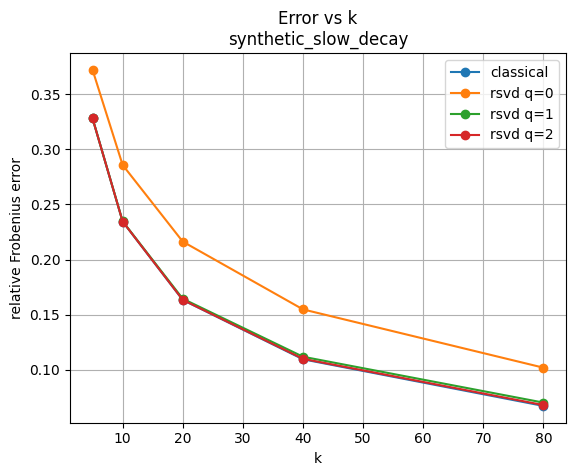

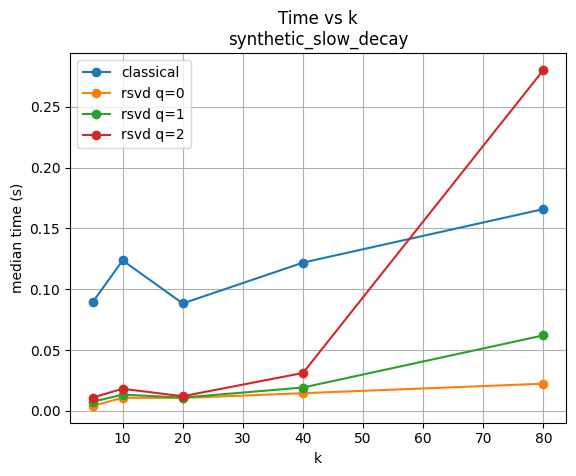

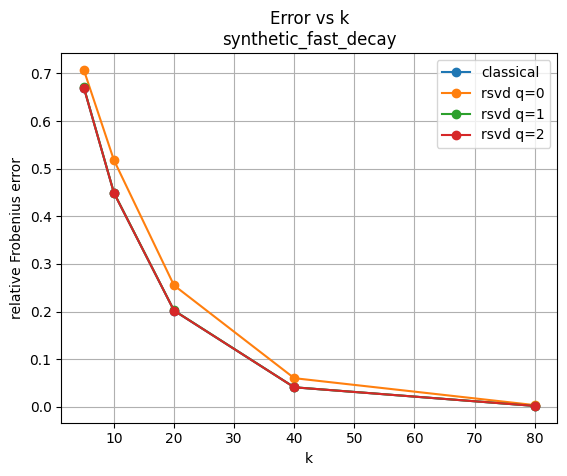

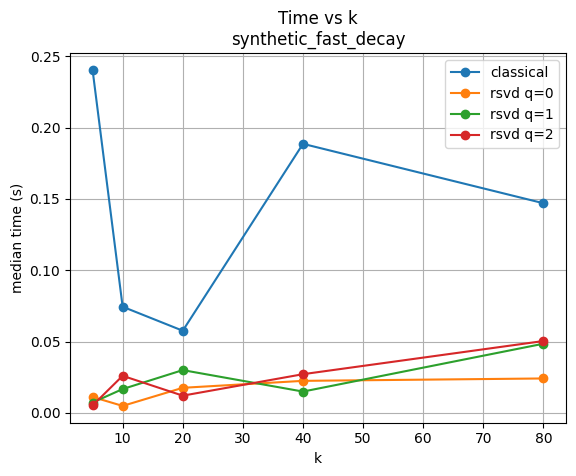

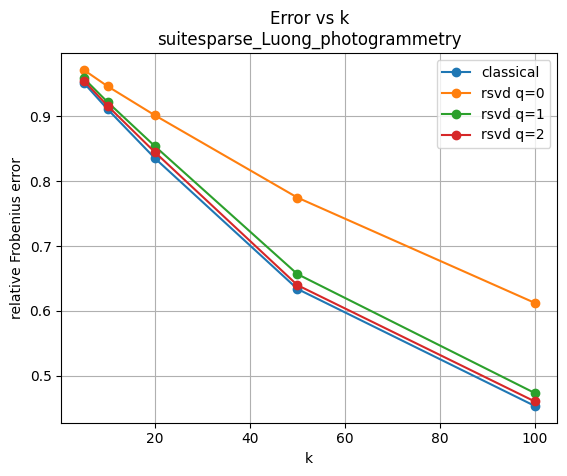

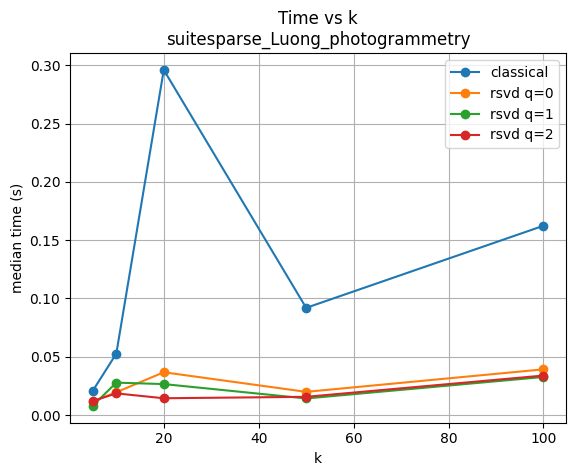

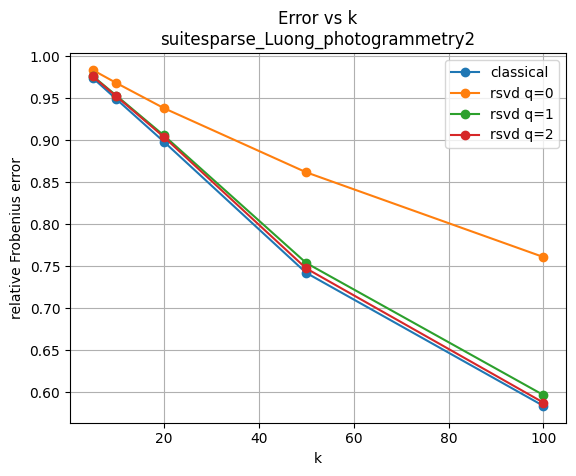

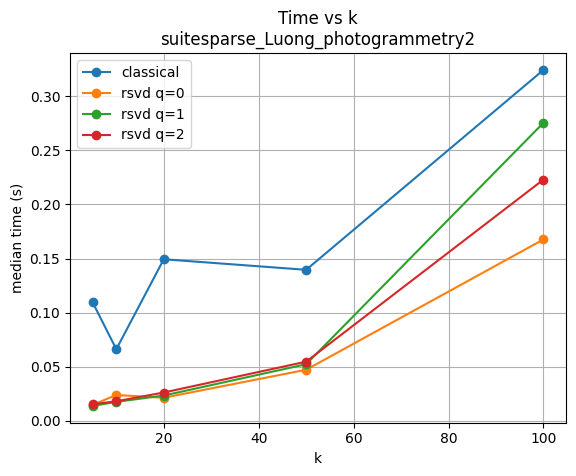

In [27]:
def plot_for_matrix(df, title):
    plt.figure()
    for method in ["classical", "rsvd"]:
        if method == "classical":
            sub = df[df["method"] == "classical"]
            plt.plot(sub["k"], sub["rel_fro_err"], marker="o", label="classical")
        else:
            for q in sorted(df[df["method"] == "rsvd"]["q"].dropna().unique()):
                sub = df[(df["method"] == "rsvd") & (df["q"] == q)]
                plt.plot(sub["k"], sub["rel_fro_err"], marker="o", label=f"rsvd q={int(q)}")
    plt.title(f"Error vs k\n{title}")
    plt.xlabel("k"); plt.ylabel("relative Frobenius error")
    plt.grid(True); plt.legend(); plt.show()

    plt.figure()
    for method in ["classical", "rsvd"]:
        if method == "classical":
            sub = df[df["method"] == "classical"]
            plt.plot(sub["k"], sub["time_s"], marker="o", label="classical")
        else:
            for q in sorted(df[df["method"] == "rsvd"]["q"].dropna().unique()):
                sub = df[(df["method"] == "rsvd") & (df["q"] == q)]
                plt.plot(sub["k"], sub["time_s"], marker="o", label=f"rsvd q={int(q)}")
    plt.title(f"Time vs k\n{title}")
    plt.xlabel("k"); plt.ylabel("median time (s)")
    plt.grid(True); plt.legend(); plt.show()

for matrix_name in res["matrix"].unique():
    plot_for_matrix(res[res["matrix"] == matrix_name], matrix_name)
